In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.tight_layout()


class BernoulliBandit:
    def __init__(self, p):
        self.p = p

    def pull(self):
        # Returns either 0 or 1.
        reward = np.random.binomial(n=1, p=self.p)
        return reward

<Figure size 640x480 with 0 Axes>

In [2]:
probs = [0.004, 0.016, 0.02, 0.028, 0.031]
ads = [BernoulliBandit(p) for p in probs]

## A/B/n Test

In [3]:
n_test = 10_000
n_prod = 90_000
n_ads = len(ads)
Q = np.zeros(n_ads)  # Q, action values.
N = np.zeros(n_ads)  # N, total impressions.
total_reward = 0
avg_rewards = []

In [4]:
for i in range(n_test):
    ad_chosen = np.random.randint(n_ads)
    R = ads[ad_chosen].pull()  # Observe reward.
    N[ad_chosen] += 1
    Q[ad_chosen] += (1 / N[ad_chosen]) * (R - Q[ad_chosen])
    total_reward += R
    avg_reward_so_far = total_reward / (i + 1)
    avg_rewards.append(avg_reward_so_far)
best_ad_index = np.argmax(Q)
print(f'The best performing ad is {chr(ord("A")+best_ad_index)}')

The best performing ad is E


In [5]:
ad_chosen = best_ad_index
for i in range(n_prod):
    R = ads[ad_chosen].pull()
    total_reward += R
    avg_reward_so_far = total_reward / (n_test + i + 1)
    avg_rewards.append(avg_reward_so_far)

<Axes: title={'center': 'A/B/n Test Avg. Reward: 0.0292'}, xlabel='Impressions', ylabel='Avg. Reward'>

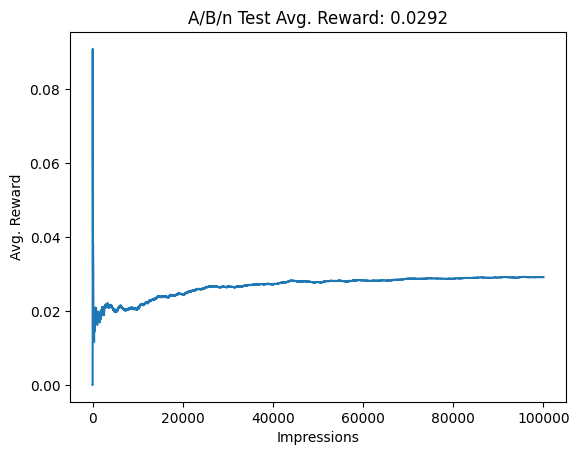

In [6]:
import pandas as pd

df_reward_comparison = pd.DataFrame(avg_rewards, columns=["A/B/n"])
df_reward_comparison["A/B/n"].plot(
    xlabel="Impressions",
    ylabel="Avg. Reward",
    title=f"A/B/n Test Avg. Reward: {avg_reward_so_far:.4f}",
)

## $\varepsilon$-greedy actions

In [7]:
eps = [0.01, 0.05, 0.1, 0.2]
for e in eps:
    n_prod = 100_000
    n_ads = len(ads)
    Q = np.zeros(n_ads)
    N = np.zeros(n_ads)
    total_reward = 0
    avg_rewards = []

    ad_chosen = np.random.randint(n_ads)
    for i in range(n_prod):
        R = ads[ad_chosen].pull()
        N[ad_chosen] += 1
        Q[ad_chosen] += (1 / N[ad_chosen]) * (R - Q[ad_chosen])
        total_reward += R
        avg_reward_so_far = total_reward / (i + 1)
        avg_rewards.append(avg_reward_so_far)

        # Select the next ad to display.
        if np.random.uniform() <= e:
            ad_chosen = np.random.randint(n_ads)
        else:
            ad_chosen = np.argmax(Q)
    df_reward_comparison[f"e-greedy: {e}"] = avg_rewards

<Axes: xlabel='Impressions', ylabel='Avg. Reward'>

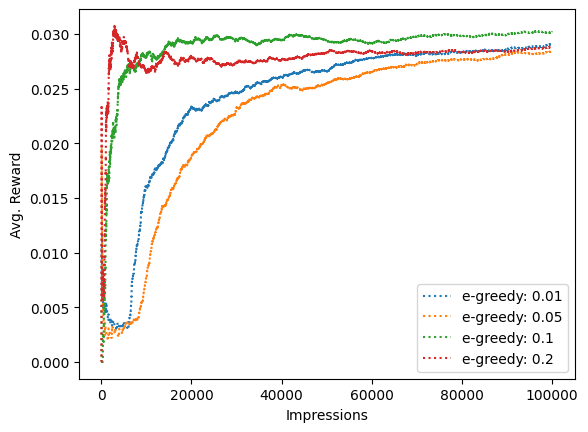

In [8]:
# We skip the first 20 rows that has high values.
df_reward_comparison[
    ["e-greedy: 0.01", "e-greedy: 0.05", "e-greedy: 0.1", "e-greedy: 0.2"]
].loc[20:, :].plot(
    xlabel="Impressions",
    ylabel="Avg. Reward",
    linestyle="dotted",
)

## Upper Confidence Bound

In [9]:
for c in [0.1, 1, 10]:
    n_prod = 100_000
    n_ads = len(ads)
    ad_indices = np.array(range(n_ads))
    Q = np.zeros(n_ads)
    N = np.zeros(n_ads)
    total_reward = 0
    avg_rewards = []

    for t in range(1, n_prod + 1):
        if any(N == 0):
            ad_chosen = np.random.choice(ad_indices[N == 0])
        else:
            uncertainty = np.sqrt(np.log(t) / N)
            ad_chosen = np.argmax(Q + c * uncertainty)
        R = ads[ad_chosen].pull()
        N[ad_chosen] += 1
        Q[ad_chosen] += (1 / N[ad_chosen]) * (R - Q[ad_chosen])
        total_reward += R
        avg_reward_so_far = total_reward / t
        avg_rewards.append(avg_reward_so_far)
    df_reward_comparison[f"UCB, c={c}"] = avg_rewards

<Axes: xlabel='Impressions', ylabel='Avg. Reward'>

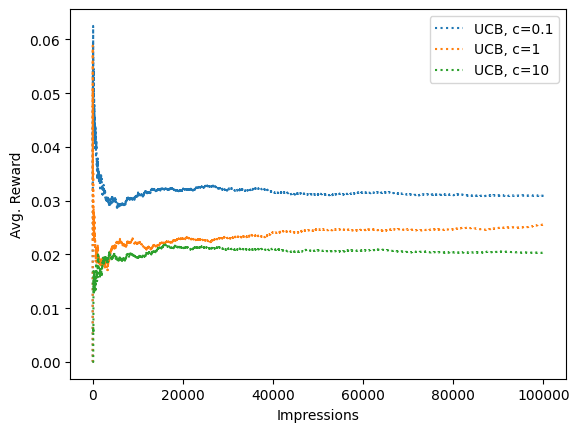

In [10]:
df_reward_comparison[["UCB, c=0.1", "UCB, c=1", "UCB, c=10"]].plot(
    xlabel="Impressions",
    ylabel="Avg. Reward",
    linestyle="dotted",
)

## Thompson Sampling

In [11]:
n_prod = 100_000
n_ads = len(ads)
alphas = np.ones(n_ads)
betas = np.ones(n_ads)
total_reward = 0
avg_rewards = []

In [12]:
for i in range(n_prod):
    theta_samples = [np.random.beta(alphas[k] + 1, betas[k] + 1) for k in range(n_ads)]
    ad_chosen = np.argmax(theta_samples)
    R = ads[ad_chosen].pull()
    alphas[ad_chosen] += R
    betas[ad_chosen] += 1 - R
    total_reward += R
    avg_reward_so_far = total_reward / (i + 1)
    avg_rewards.append(avg_reward_so_far)
df_reward_comparison["Thompson Sampling"] = avg_rewards

<Axes: xlabel='Impressions', ylabel='Avg. Reward'>

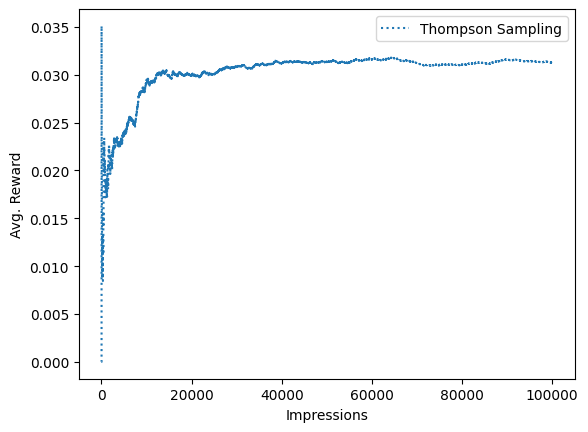

In [13]:
df_reward_comparison[["Thompson Sampling"]].plot(
    xlabel="Impressions",
    ylabel="Avg. Reward",
    linestyle="dotted",
)

<Axes: xlabel='Impressions', ylabel='Avg. Reward'>

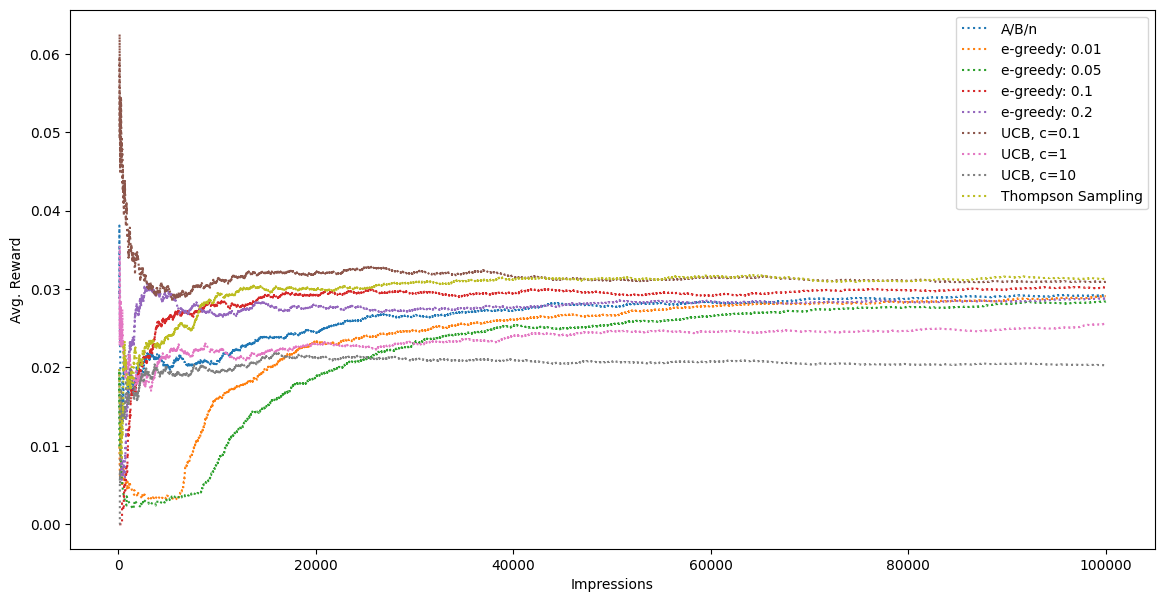

In [14]:
df_reward_comparison.iloc[100:].plot(
    xlabel="Impressions", ylabel="Avg. Reward", linestyle="dotted", figsize=(14, 7)
)